#### This notebook shows how to read the fastMRI dataset and apply some simple transformations to the data.

In [27]:
# Testing if integration works

In [105]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt
from fastmri import evaluate
import torch
from torch.nn import functional as F


Each file corresponds to one MRI scan and contains the k-space data, ground truth and some meta data related to the scan.

# Masked Testing Data

In [106]:
test_data = '../data/singlecoil_test/file1000022.h5'
hf = h5py.File(test_data)
#file_name2 = '../data/singlecoil_test/file1000022.h5'
#file_name3 = '../data/singlecoil_test/file1000055.h5'
#hf2 = h5py.File(file_name2)
#hf3 = h5py.File(file_name3)

In [107]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'mask']
Attrs: {'acceleration': 8, 'acquisition': 'CORPDFS_FBK', 'num_low_frequency': 15, 'patient_id': 'e24dd3dc05085077e65af05fc5d4c439e5e338e58926c4f344274080bd7f7cdd'}


In multi-coil MRIs, k-space has the following shape:
(number of slices, number of coils, height, width)

For single-coil MRIs, k-space has the following shape:
(number of slices, height, width)

MRIs are acquired as 3D volumes, the first dimension is the number of 2D slices.

In [108]:
volume_kspace = hf['kspace'][()]
#volume_kspace2 = hf2['kspace'][()]
#volume_kspace3 = hf3['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(37, 640, 368)


In [109]:
slice_kspace = volume_kspace

Let's see what the absolute value of k-space looks like:

In [110]:
def show_multiple_slices(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        image = data[num]
        #print(image.shape)
        length = image.shape[0]
        width = image.shape[1]
        pad_l = (length - 320)//2
        pad_w = (width - 320)//2
        true_image = image[pad_l:(length-pad_l), pad_w:(width-pad_w)]
        plt.imshow(true_image, cmap=cmap)

In [111]:
#def show_slice(data, cmap=None):
    #fig = plt.figure()
    #plt.imshow(data, cmap=cmap)

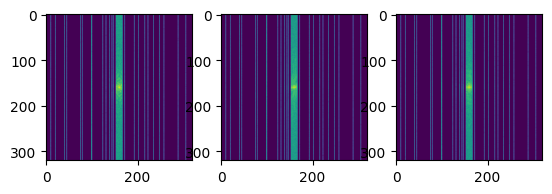

In [112]:
show_multiple_slices(np.log(np.abs(slice_kspace) + 1e-9), [10,20,30]) #show the 10th, 20th, and 30th slices

The fastMRI repo contains some utlity functions to convert k-space into image space. These functions work on PyTorch Tensors. The to_tensor function can convert Numpy arrays to PyTorch Tensors.

In [113]:
import fastmri
from fastmri.data import transforms as T

In [126]:
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

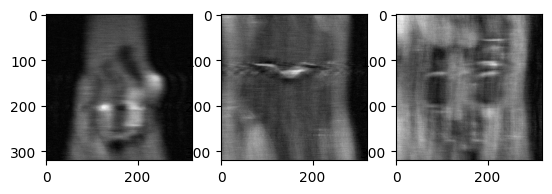

In [127]:
show_multiple_slices(slice_image_abs, [10,20,30], cmap='gray')

MR imaging is an indirect process, whereby cross-sectional images of the subject’s anatomy are
produced from frequency and phase measurements instead of direct, spatially-resolved measurements. As we can see, each image in the dataset focuses on a different snapshot of the subject's anatomy. These slices can be combined into the full image using the Root-Sum-of-Squares (RSS) transform.

In [117]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)

# Before Reconstruction

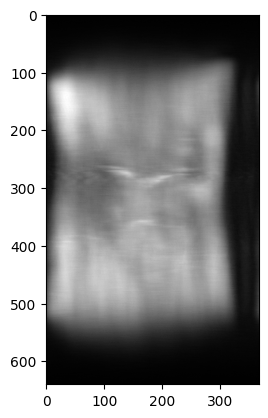

In [118]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')

# After Reconstruction

In [119]:
reconstructed = 'fastmri_examples/unet/output_test/reconstructions/file1000022.h5'
hf_r = h5py.File(reconstructed)

In [120]:
print('Keys:', list(hf_r.keys()))
print('Attrs:', dict(hf_r.attrs))

Keys: ['reconstruction']
Attrs: {}


In [121]:
volume_kspace_r = torch.tensor(hf_r['reconstruction'][()].squeeze(1))
print(volume_kspace_r.dtype)
print(volume_kspace_r.shape)

torch.float32
torch.Size([37, 320, 320])


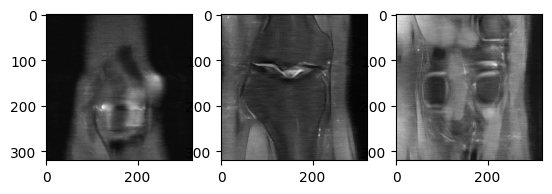

In [122]:
show_multiple_slices(volume_kspace_r, [10,20,30], cmap='gray') #show the 10th, 20th, and 30th slices

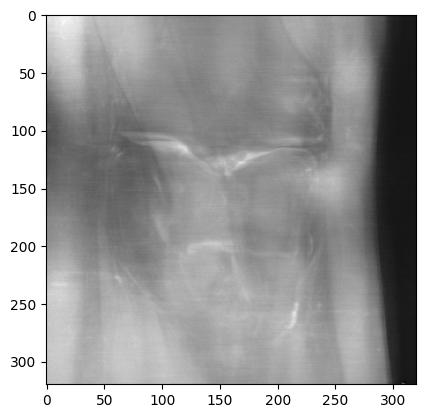

In [123]:
slice_image_rss = fastmri.rss(volume_kspace_r, dim=0)
plt.imshow(np.abs(slice_image_rss), cmap='gray')

# Simulating Under-Sampled Data

So far, we have been looking at fully-sampled data. We can simulate under-sampled data by creating a mask and applying it to k-space.

In [147]:
from fastmri.data.subsample import RandomMaskFunc
mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object

In [148]:
masked_kspace, mask, _ = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space

Let's see what the subsampled image looks like:

In [149]:
sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)

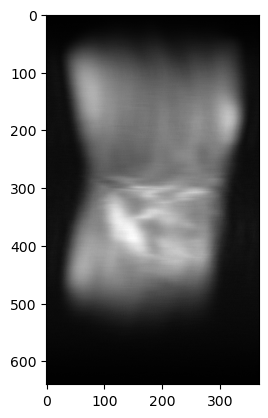

In [150]:
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')

# Calculating Reconstruction Error (L1, NMSE, PSNR, SSIM)

We used an emulated single-coil (ESC) methodology to simulate single-coil data from a multi-coil
acquisition [43]. ESC computes a complex-valued linear combination of the responses from multiple
coils, with the linear combination fitted to the ground-truth root-sum-of-squares reconstruction in
the least-squares sense.

In [142]:
import os

def recon_errors(original_dir, recon_dir):
    # assign directory
    #directory = 'fastmri_examples/unet/output_test/reconstructions'
    
    l1 = []
    nmse = []
    psnr = []
    ssim = []

    # iterate over files in
    # that directory
    for filename in os.listdir(recon_dir):

        #testing image (the original)
        val_image = f'{original_dir}/{filename}'
        hf = h5py.File(val_image)
        val_kspace = hf['kspace'][()]
        slice_kspace2 = T.to_tensor(val_kspace)      # Convert from numpy array to pytorch tensor
        slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
        slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image
        length = slice_image_abs.shape[1]
        width = slice_image_abs.shape[2]
        pad_l = (length - 320)//2
        pad_w = (width - 320)//2
        true_image = slice_image_abs[:,pad_l:(length-pad_l), pad_w:(width-pad_w)]

        #reconstructed image
        recon_image = f'{recon_dir}/{filename}'
        recon_hf = h5py.File(recon_image)
        pred_image = torch.tensor(recon_hf['reconstruction'][()].squeeze(1))
        
        #l1_loss
        l1.append(F.l1_loss(true_image, pred_image))

        #nmse
        nmse.append(evaluate.nmse(true_image.numpy(), pred_image.numpy()))

        #psnr
        psnr.append(evaluate.psnr(true_image.numpy(), pred_image.numpy()))

        #ssmr
        ssim.append(evaluate.ssim(true_image.numpy(), pred_image.numpy()))
    
    return np.mean(l1), np.mean(nmse), np.mean(psnr), np.mean(ssim)

In [143]:
mean_l1, mean_nmse, mean_psnr, mean_ssim = recon_errors("../data/singlecoil_test",'fastmri_examples/unet/output_test/reconstructions')

In [144]:
print(mean_l1)


4.7076296e-06


In [145]:
print(mean_nmse)

0.013380001998489844


In [146]:
print(mean_psnr)

33.405006424581195


In [147]:
print(mean_ssim)

0.893117744406068
